<a href="https://colab.research.google.com/github/Diego251Fagundes/Data-Science-Machine-Learning-Studies/blob/main/Atividade_Pratica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercícios com Storytelling — SVM, Árvores de Decisão, Florestas Aleatórias e Boosting

**Objetivo:** Este notebook gera datasets sintéticos reprodutíveis e apresenta 12 exercícios com storytelling. Inclui uma seção de teoria sobre **Boosting** (AdaBoost, Gradient Boosting, XGBoost) comparando com Random Forest, SVM e Árvores.

**Reprodutibilidade:** `numpy.random.seed(42)` e `random.seed(42)`.
**Arquivos de dados:** serão salvos em `/mnt/data` quando você executar a célula de geração.


## 00. Teoria — Boosting em detalhe (AdaBoost, Gradient Boosting, XGBoost) e comparação crítica

**Boosting** combina **modelos fracos** (geralmente árvores rasas) de forma **sequencial e aditiva**, focando iterativamente nos **erros** anteriores.  
- **Bagging (Random Forest)**: modelos treinados **em paralelo** em *bootstraps*, reduzindo **variância**.  
- **Boosting**: em geral reduz **viés**, podendo aumentar variância se mal regularizado.

### AdaBoost (Freund & Schapire, 1997)
- Repondera exemplos, aumentando o peso dos mal classificados; agrega fracos-aprendizes por soma ponderada.  
- Sensível a **ruído de rótulo**; regularize com `learning_rate` menor e limite `n_estimators`.

### Gradient Boosting (Friedman, 2001)
- Vê boosting como **descida de gradiente funcional** em espaço de funções.  
- Ajusta árvores aos **pseudo-gradientes** da perda (ex.: log-loss para classificação).  
- Mais estável que AdaBoost em dados ruidosos; variantes suportam **subamostragem** e **early stopping**.

### XGBoost
- Otimizações (paralelismo, esparsidade) + **regularização L1/L2**.  
- Hiperparâmetros: `learning_rate`, `n_estimators`, `max_depth`, `subsample`, `colsample_bytree`, `reg_lambda`, `reg_alpha`.  
- Use **early stopping** com validação.

### Tabela comparativa
| Aspecto | Boosting | Random Forest (Bagging) | SVM | Árvore |
|---|---|---|---|---|
| Treino | Sequencial | Paralelo (bootstraps) | Otimiza margem | Guloso |
| Viés/Variância | ↓Viés (↑Variância se mal tunado) | ↓Variância | Depende de kernel/C | Alto viés/variância sem poda |
| Ruído de rótulo | Sensível (Ada) / Moderado (GBM) | Robusta moderada | Sensível a outliers (sem slack) | Sensível |
| Escala | Pouco sensível (árvores) | Pouco sensível | **Muito sensível** | Pouco sensível |
| Interpretabilidade | Média (SHAP/imp.) | Média (imp.) | Baixa (RBF) | **Alta** |
| Tuning | **Crítico** | Moderado | **Crítico** | Baixo–moderado |

**Boas práticas:** learning rate pequeno + mais árvores; subsample/colsample; early stopping; métricas adequadas em minoria (AUC-PR); calibração quando necessário.


## 0. Geração de Datasets
Execute a célula abaixo **uma vez** para criar todos os CSVs em `/mnt/data`.

In [ ]:

# Geração dos 12 datasets
import numpy as np, pandas as pd, os, random
from sklearn.datasets import make_classification, make_circles

np.random.seed(42); random.seed(42)
out_dir = "/mnt/data"; os.makedirs(out_dir, exist_ok=True)

def save(df, name): df.to_csv(f"{out_dir}/{name}", index=False)

# 1
X1, y1 = make_circles(n_samples=300, noise=0.10, factor=0.5, random_state=42)
df = pd.DataFrame(X1, columns=["proteina_A","proteina_B"]); df["resposta"]=y1.astype(int); save(df, "01_imunoterapia_circulos.csv")

# 2
X2, y2 = make_classification(n_samples=300, n_features=500, n_informative=15, n_redundant=10, n_classes=3, class_sep=1.2, random_state=42)
genes=[f"gene_{i}" for i in range(1,501)]; df=pd.DataFrame(X2, columns=genes); df["tratamento"]=pd.Series(y2).map({0:"A",1:"B",2:"C"}); save(df,"02_ratinhos_expressao_500genes.csv")

# 3
comprimento=np.random.normal(10,2,200); largura=np.random.normal(3,0.8,200); razao=comprimento/largura; mutante=(razao>3.2).astype(int)
df=pd.DataFrame({"comprimento":comprimento,"largura":largura,"razao_LW":razao,"mutante":mutante}); save(df,"03_folhas_morfometria.csv")

# 4
n=200; peso=np.clip(np.random.normal(22,9,n),3,60); idade=np.clip(np.random.normal(7.5,3.2,n),0.4,16); freq=np.clip(np.random.normal(95,18,n),50,180); t4=np.clip(np.random.normal(1.8,0.6,n),0.1,5)
diagnostico=(((t4<1.2)&(idade>7))|(freq<70)).astype(int); flip=np.random.choice(n,size=int(0.1*n),replace=False); diagnostico[flip]=1-diagnostico[flip]
df=pd.DataFrame({"peso":peso,"idade":idade,"frequencia_cardiaca":freq,"t4_serico":t4,"diagnostico":diagnostico}); save(df,"04_caes_hipotireoidismo.csv")

# 5
X5,y5=make_classification(n_samples=400,n_features=10000,n_informative=30,n_redundant=0,n_clusters_per_class=2,class_sep=1.0,random_state=42)
df=pd.DataFrame(X5,columns=[f"gene_{i}" for i in range(1,10001)]); df["diagnostico"]=y5.astype(int); save(df,"05_alzheimer_10000genes.csv")

# 6
n=300; temperatura=np.random.normal(15,5,n); polen=np.random.normal(120,40,n); acarose=np.random.normal(10,3,n); umidade=np.random.normal(60,10,n)
sobreviveu=((polen>100)&(acarose<12)).astype(int); flip=np.random.choice(n,size=int(0.08*n),replace=False); sobreviveu[flip]=1-sobreviveu[flip]
df=pd.DataFrame({"temperatura_media":temperatura,"polen":polen,"acarose":acarose,"umidade":umidade,"sobreviveu":sobreviveu}); save(df,"06_abelhas_sobrevivencia.csv")

# 7
X7,y7=make_classification(n_samples=300,n_features=10,n_informative=8,n_redundant=0,n_classes=3,class_sep=1.0,random_state=42)
df=pd.DataFrame(X7,columns=[f"gene_res{chr(65+i)}" for i in range(10)]); df["classe_resistencia"]=pd.Series(y7).map({0:"A",1:"B",2:"C"}); save(df,"07_ecoli_resistencia.csv")

# 8
n=250; idade=np.random.randint(25,81,n); col=np.random.normal(200,40,n); press=np.random.normal(120,15,n); bmi=np.random.normal(27,4,n); tabag=np.random.choice([0,1],size=n,p=[0.7,0.3])
risco=((idade>55)&(col>240)|((press>135)&(bmi>30))).astype(int); df=pd.DataFrame({"idade":idade,"colesterol":col,"pressao":press,"bmi":bmi,"tabagismo":tabag,"risco":risco}); save(df,"08_risco_cardiovascular.csv")

# 9
X9,y9=make_classification(n_samples=300,n_features=3,n_informative=3,n_redundant=0,n_classes=2,flip_y=0.15,random_state=42)
df=pd.DataFrame(X9,columns=["glicose","variabilidade_sensorial","ruido"]); df["paciente_id"]=np.random.randint(1000,2000,300); df["alerta"]=y9.astype(int)
df=df[["paciente_id","glicose","variabilidade_sensorial","ruido","alerta"]]; save(df,"09_sensor_glicose_ruido.csv")

# 10
X10,y10=make_classification(n_samples=500,n_features=20,n_informative=10,n_redundant=5,n_classes=2,class_sep=1.0,random_state=42)
df=pd.DataFrame(X10,columns=[f"var_{i}" for i in range(1,21)]); df["mortalidade"]=y10.astype(int); save(df,"10_uti_mortalidade_20vars.csv")

# B1
Xb1,yb1=make_classification(n_samples=1000,n_features=12,n_informative=6,weights=[0.97,0.03],n_classes=2,random_state=42)
df=pd.DataFrame(Xb1,columns=[f"var_{i}" for i in range(1,13)]); df["doenca_rara"]=yb1.astype(int); save(df,"B1_doenca_rara_desbalanceado.csv")

# B2
Xb2,yb2=make_classification(n_samples=200,n_features=500,n_informative=60,n_redundant=20,n_classes=4,class_sep=1.2,random_state=42)
df=pd.DataFrame(Xb2,columns=[f"snp_{i}" for i in range(1,501)]); df["origem"]=pd.Series(yb2).map({0:"AFR",1:"AMR",2:"EAS",3:"EUR"}); save(df,"B2_genomas_snps_500.csv")

print('Arquivos gerados em /mnt/data.')


Arquivos gerados em /mnt/data.


### 0.1 Demonstração — AdaBoost (dataset B1: doença rara)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, classification_report
import pandas as pd

# Dataset de doença rara (3% positivos)
df = pd.read_csv('/mnt/data/B1_doenca_rara_desbalanceado.csv')
X = df.drop(columns=['doenca_rara']).values
y = df['doenca_rara'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# OBS: nas versões recentes, use "estimator=" e não "base_estimator="
clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
    n_estimators=200,
    learning_rate=0.1,
    random_state=42
)

clf.fit(X_train, y_train)

y_proba = clf.predict_proba(X_test)[:, 1]
y_pred = clf.predict(X_test)

print("AUC-PR (classe positiva rara):", average_precision_score(y_test, y_proba))
print(classification_report(y_test, y_pred, digits=3))

AUC-PR (classe positiva rara): 0.279970163066259
              precision    recall  f1-score   support

           0      0.964     1.000     0.982       241
           1      0.000     0.000     0.000         9

    accuracy                          0.964       250
   macro avg      0.482     0.500     0.491       250
weighted avg      0.929     0.964     0.946       250



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 0.2 Demonstração — Gradient Boosting (dataset 10: UTI)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
import pandas as pd

df = pd.read_csv('/mnt/data/10_uti_mortalidade_20vars.csv')
X = df.drop(columns=['mortalidade']).values
y = df['mortalidade'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

gbm = GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=400,
    max_depth=3,
    random_state=42
)
gbm.fit(X_train, y_train)

y_proba = gbm.predict_proba(X_test)[:,1]
y_pred = gbm.predict(X_test)

print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred, digits=3))

ROC AUC: 0.9554531490015361
              precision    recall  f1-score   support

           0      0.964     0.871     0.915        62
           1      0.884     0.968     0.924        63

    accuracy                          0.920       125
   macro avg      0.924     0.920     0.920       125
weighted avg      0.924     0.920     0.920       125



## 1. O Diagnóstico Impossível — SVM Linear vs. RBF

**Contexto:** Classificar resposta à imunoterapia a partir de proteínas séricas (`proteina_A`, `proteina_B`).

**Arquivo:** `/mnt/data/01_imunoterapia_circulos.csv`

**Tarefas:**

1) Treine SVM linear e SVM com kernel RBF.

2) Compare graficamente as fronteiras de decisão.

3) Explique (em linguagem biomédica) hiperplano e vetores de suporte.

**Métrica sugerida:** Acurácia e visualização 2D.


In [ ]:
# Starter: ajuste caminho/coluna-alvo conforme o exercício
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.svm import SVC

df = pd.read_csv('/mnt/data/01_imunoterapia_circulos.csv')  # <-- ajuste aqui
X = df.drop(columns=['resposta'])                            # <-- ajuste aqui
y = df['resposta']                                          # <-- ajuste aqui

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Ex.: scaler quando apropriado (SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# TODO: implemente os modelos do exercício (SVM/Árvore/RandomForest/Boosting), tuning e avaliação.

# 1. Treine SVM linear e SVM com kernel RBF.
# SVM Linear
svm_linear = SVC(kernel='linear', random_state=42)
svm_linear.fit(X_train_scaled, y_train)
y_pred_linear = svm_linear.predict(X_test_scaled)
acc_linear = accuracy_score(y_test, y_pred_linear)

# SVM RBF
svm_rbf = SVC(kernel='rbf', random_state=42)
svm_rbf.fit(X_train_scaled, y_train)
y_pred_rbf = svm_rbf.predict(X_test_scaled)
acc_rbf = accuracy_score(y_test, y_pred_rbf)

print(f"Acurácia SVM Linear: {acc_linear:.4f}")
print(f"Acurácia SVM RBF: {acc_rbf:.4f}")



Acurácia SVM Linear: 0.4533
Acurácia SVM RBF: 1.0000


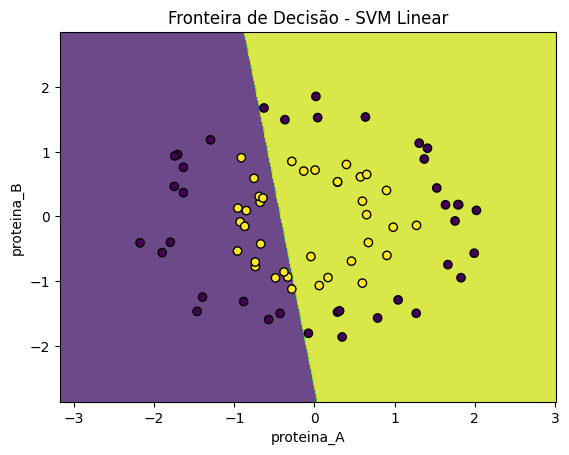

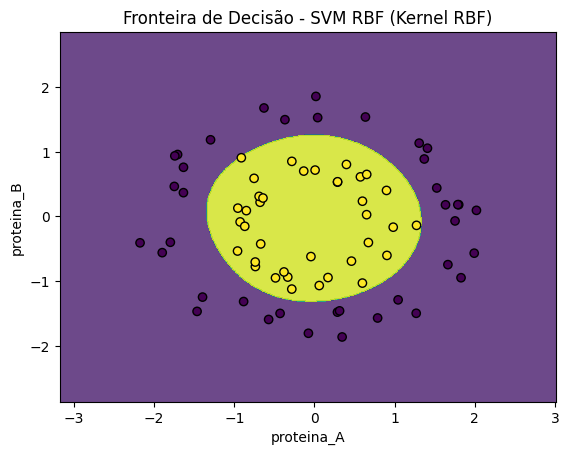

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_decision_boundary(X, y, classifier, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.title(title)
    plt.xlabel('proteina_A')
    plt.ylabel('proteina_B')
    plt.show()

# Plot SVM Linear
plot_decision_boundary(X_test_scaled, y_test, svm_linear, 'Fronteira de Decisão - SVM Linear')

# Plot SVM RBF
plot_decision_boundary(X_test_scaled, y_test, svm_rbf, 'Fronteira de Decisão - SVM RBF (Kernel RBF)')

**Hiperplano:** Imagine que você está tentando separar dois grupos de células (por exemplo, células saudáveis e células doentes) com base em duas características (como a expressão de duas proteínas diferentes). Um hiperplano é como uma linha (em 2D) ou um plano (em 3D) que tenta dividir esses dois grupos da melhor maneira possível. O objetivo do SVM é encontrar o "melhor" hiperplano que maximiza a margem entre os grupos.

**Vetores de Suporte:** Os vetores de suporte são os "exemplos" de células que estão mais próximos do hiperplano. Eles são os pontos cruciais que definem a posição e a orientação do hiperplano. Pense neles como as células "limítrofes" que são mais difíceis de classificar. O SVM foca nesses vetores de suporte para encontrar a melhor separação. Se você remover um vetor de suporte, o hiperplano pode mudar. Se você remover uma célula que não é um vetor de suporte, o hiperplano provavelmente não mudará.


---



## 2. O Mistério dos Ratinhos — SVM + Ajuste de Parâmetros

**Contexto:** Expressão gênica (500 features) para identificar o tratamento (A/B/C).

**Arquivo:** `/mnt/data/02_ratinhos_expressao_500genes.csv`

**Tarefas:**

1) Padronize as features (StandardScaler).

2) Use GridSearchCV para ajustar `C` e `gamma` do SVM (RBF).

3) Avalie com matriz de confusão e classificação por classe.


Melhores parâmetros: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
Melhor acurácia cross-val: 0.4916666666666667

Avaliação no conjunto de teste:
Acurácia: 0.55

Matriz de Confusão:
 [[ 8  0 12]
 [ 6  9  5]
 [ 4  0 16]]

Relatório de Classificação:
               precision    recall  f1-score   support

           A       0.44      0.40      0.42        20
           B       1.00      0.45      0.62        20
           C       0.48      0.80      0.60        20

    accuracy                           0.55        60
   macro avg       0.64      0.55      0.55        60
weighted avg       0.64      0.55      0.55        60



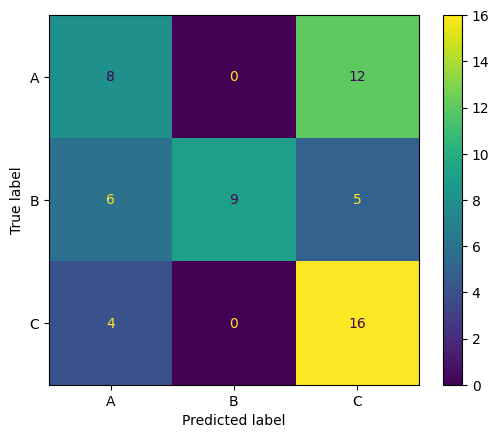

In [ ]:
# Starter: ajuste caminho/coluna-alvo conforme o exercício
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# Carregar o dataset correto para este exercício
df = pd.read_csv('/mnt/data/02_ratinhos_expressao_500genes.csv')  # <-- ajuste aqui
X = df.drop(columns=['tratamento'])                            # <-- ajuste aqui
y = df['tratamento']                                          # <-- ajuste aqui

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 1. Padronize as features (StandardScaler).
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 2. Use GridSearchCV para ajustar C e gamma do SVM (RBF).
# Definir os parâmetros a serem testados
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}

# Criar o modelo SVM
svm = SVC(random_state=42)

# Configurar o GridSearchCV
grid_search = GridSearchCV(svm, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Treinar o GridSearchCV nos dados de treino escalados
grid_search.fit(X_train_scaled, y_train)

# Exibir os melhores parâmetros encontrados
print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor acurácia cross-val:", grid_search.best_score_)

# Obter o melhor modelo treinado
best_svm = grid_search.best_estimator_

# 3. Avalie com matriz de confusão e classificação por classe.
y_pred = best_svm.predict(X_test_scaled)

print("\nAvaliação no conjunto de teste:")
print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))

# Plotar a matriz de confusão
cm = confusion_matrix(y_test, y_pred, labels=best_svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_svm.classes_)
disp.plot()
plt.show()




---


## 3. As Folhas e o Gene Mutante — Árvore de Decisão

**Contexto:** Morfometria de folhas com marcador `mutante`.

**Arquivo:** `/mnt/data/03_folhas_morfometria.csv`

**Tarefas:**

1) Treine árvore usando critérios Gini e Entropia.

2) Visualize a árvore e interprete as divisões biológicas.


Acurácia Árvore (Gini): 1.0000
Acurácia Árvore (Entropia): 1.0000


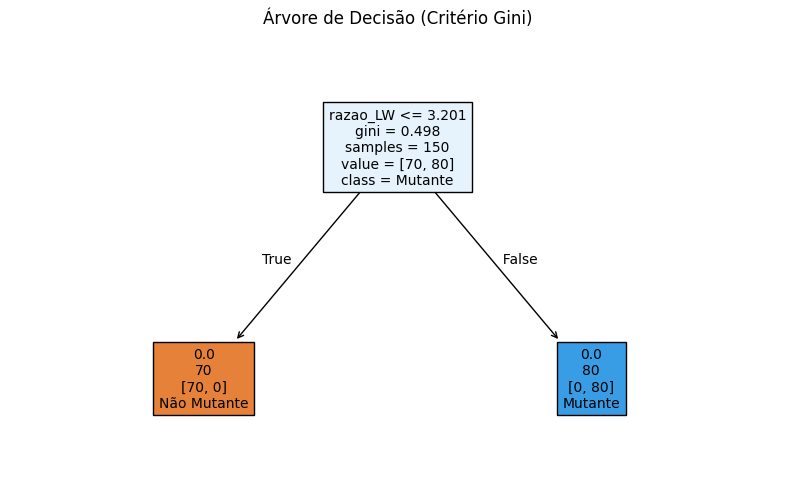

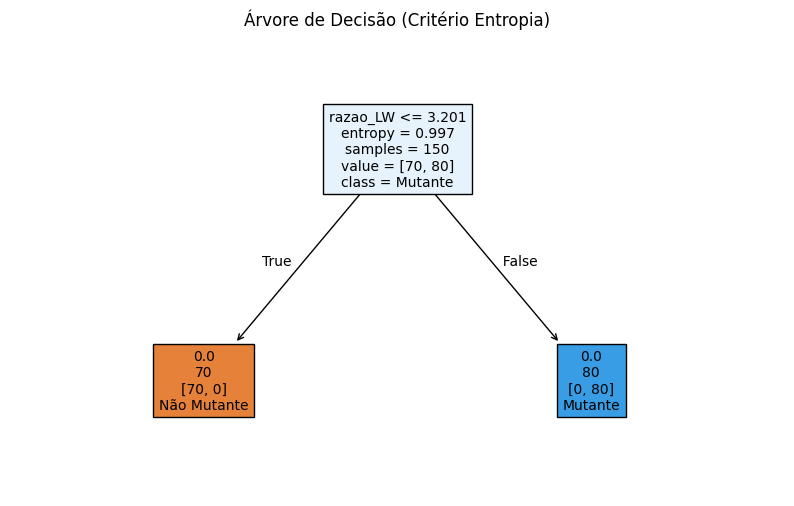

In [ ]:
# Starter: ajuste caminho/coluna-alvo conforme o exercício
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

df = pd.read_csv('/mnt/data/03_folhas_morfometria.csv')  # <-- ajuste aqui
X = df.drop(columns=['mutante'])                            # <-- ajuste aqui
y = df['mutante']                                          # <-- ajuste aqui

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Ex.: scaler quando apropriado (SVM)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled  = scaler.transform(X_test)

# TODO: implemente os modelos do exercício (SVM/Árvore/RandomForest/Boosting), tuning e avaliação.

# 1. Treine árvore usando critérios Gini e Entropia.
# Árvore com critério Gini
tree_gini = DecisionTreeClassifier(criterion='gini', random_state=42)
tree_gini.fit(X_train, y_train)
y_pred_gini = tree_gini.predict(X_test)
acc_gini = accuracy_score(y_test, y_pred_gini)

# Árvore com critério Entropia
tree_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42)
tree_entropy.fit(X_train, y_train)
y_pred_entropy = tree_entropy.predict(X_test)
acc_entropy = accuracy_score(y_test, y_pred_entropy)

print(f"Acurácia Árvore (Gini): {acc_gini:.4f}")
print(f"Acurácia Árvore (Entropia): {acc_entropy:.4f}")

# 2. Visualize a árvore e interprete as divisões biológicas.
# Visualize a árvore com critério Gini
plt.figure(figsize=(10, 6))
plot_tree(tree_gini, feature_names=X.columns, filled=True, class_names=['Não Mutante', 'Mutante'], fontsize=10, label='root')
plt.title('Árvore de Decisão (Critério Gini)')
plt.show()

# Visualize a árvore com critério Entropia
plt.figure(figsize=(10, 6))
plot_tree(tree_entropy, feature_names=X.columns, filled=True, class_names=['Não Mutante', 'Mutante'], fontsize=10, label='root')
plt.title('Árvore de Decisão (Critério Entropia)')
plt.show()



---


## 4. A Clínica dos Cães — Overfitting em Árvores

**Contexto:** Hipotireoidismo canino com rótulos ruidosos (10%).

**Arquivo:** `/mnt/data/04_caes_hipotireoidismo.csv`

**Tarefas:**

1) Treine árvore profunda vs. árvore podada (`max_depth`, `min_samples_leaf`).

2) Compare acurácia de treino e teste. Discuta overfitting.


In [ ]:
# Starter: ajuste caminho/coluna-alvo conforme o exercício
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

df = pd.read_csv('/mnt/data/04_caes_hipotireoidismo.csv')  # <-- ajuste aqui
X = df.drop(columns=['diagnostico'])                            # <-- ajuste aqui
y = df['diagnostico']                                          # <-- ajuste aqui

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Ex.: scaler quando apropriado (SVM)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled  = scaler.transform(X_test)

# TODO: implemente os modelos do exercício (SVM/Árvore/RandomForest/Boosting), tuning e avaliação.

# 1. Treine árvore profunda vs. árvore podada (max_depth, min_samples_leaf).
# Árvore profunda (potencialmente com overfitting)
tree_deep = DecisionTreeClassifier(random_state=42) # Default parameters allow deep trees
tree_deep.fit(X_train, y_train)

# Árvore podada
tree_pruned = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, random_state=42) # Example pruning parameters
tree_pruned.fit(X_train, y_train)

# 2 Compare acurácia de treino e teste. Discuta overfitting.
y_pred_deep_train = tree_deep.predict(X_train)
y_pred_deep_test = tree_deep.predict(X_test)
acc_deep_train = accuracy_score(y_train, y_pred_deep_train)
acc_deep_test = accuracy_score(y_test, y_pred_deep_test)

y_pred_pruned_train = tree_pruned.predict(X_train)
y_pred_pruned_test = tree_pruned.predict(X_test)
acc_pruned_train = accuracy_score(y_train, y_pred_pruned_train)
acc_pruned_test = accuracy_score(y_test, y_pred_pruned_test)

print(f"Acurácia Árvore Profunda (Treino): {acc_deep_train:.4f}")
print(f"Acurácia Árvore Profunda (Teste): {acc_deep_test:.4f}")
print(f"Acurácia Árvore Podada (Treino): {acc_pruned_train:.4f}")
print(f"Acurácia Árvore Podada (Teste): {acc_pruned_test:.4f}")

Acurácia Árvore Profunda (Treino): 1.0000
Acurácia Árvore Profunda (Teste): 0.8200
Acurácia Árvore Podada (Treino): 0.8667
Acurácia Árvore Podada (Teste): 0.8600




---


## 5. Sequenciamento de Mistérios — Random Forest & Importância de Genes

**Contexto:** Expressão de 10.000 genes para diagnóstico binário.

**Arquivo:** `/mnt/data/05_alzheimer_10000genes.csv`

**Tarefas:**

1) Treine RandomForest e extraia `feature_importances_`.

2) Liste top-10 genes e discuta a relevância.


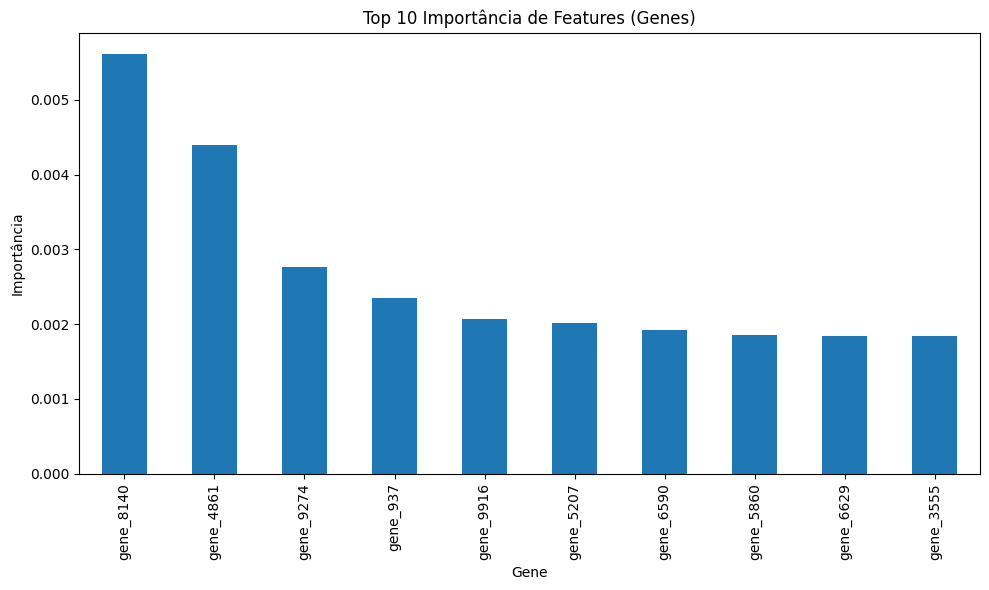

In [ ]:
# Starter: ajuste caminho/coluna-alvo conforme o exercício
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

df = pd.read_csv('/mnt/data/05_alzheimer_10000genes.csv')  # <-- ajuste aqui
X = df.drop(columns=['diagnostico'])                            # <-- ajuste aqui
y = df['diagnostico']                                          # <-- ajuste aqui

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# TODO: implemente os modelos do exercício (SVM/Árvore/RandomForest/Boosting), tuning e avaliação.

# 1. Treine RandomForest e extraia feature_importances_.
# Treinar RandomForest
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Extrair feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)

# Listar top-10 genes
top_10_genes = feature_importances.nlargest(10)

# Opcional: Visualizar as importâncias
plt.figure(figsize=(10, 6))
top_10_genes.plot(kind='bar')
plt.title('Top 10 Importância de Features (Genes)')
plt.ylabel('Importância')
plt.xlabel('Gene')
plt.tight_layout()
plt.show()



---


## 6. O Estudo das Abelhas — Bagging e Robustez

**Contexto:** Sobrevivência de colmeias no inverno.

**Arquivo:** `/mnt/data/06_abelhas_sobrevivencia.csv`

**Tarefas:**

1) Compare árvore única vs. RandomForest(100).

2) Discuta variância/estabilidade entre execuções.


In [ ]:
# Starter: ajuste caminho/coluna-alvo conforme o exercício
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv('/mnt/data/06_abelhas_sobrevivencia.csv')  # <-- ajuste aqui
X = df.drop(columns=['sobreviveu'])                            # <-- ajuste aqui
y = df['sobreviveu']                                          # <-- ajuste aqui

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# TODO: implemente os modelos do exercício (SVM/Árvore/RandomForest/Boosting), tuning e avaliação.

# 1. Compare árvore única vs. RandomForest(100).
# Árvore única
tree_single = DecisionTreeClassifier(random_state=42)
tree_single.fit(X_train, y_train)
y_pred_single = tree_single.predict(X_test)
acc_single = accuracy_score(y_test, y_pred_single)

# RandomForest (100 árvores)
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)

print(f"Acurácia Árvore Única: {acc_single:.4f}")
print(f"Acurácia RandomForest (100 árvores): {acc_rf:.4f}")

Acurácia Árvore Única: 0.9067
Acurácia RandomForest (100 árvores): 0.9067




---


## 7. A Bactéria Rebelde — SVM Multiclasse

**Contexto:** Resistência antimicrobiana em E. coli (A/B/C).

**Arquivo:** `/mnt/data/07_ecoli_resistencia.csv`

**Tarefas:**

1) SVM multiclasse (one-vs-rest) com padronização.

2) Avalie precisão por classe e analise confusões.


Avaliação do modelo SVM Multiclasse no conjunto de teste:

Relatório de Classificação:
               precision    recall  f1-score   support

           A      0.714     0.800     0.755        25
           B      0.786     0.880     0.830        25
           C      0.947     0.720     0.818        25

    accuracy                          0.800        75
   macro avg      0.816     0.800     0.801        75
weighted avg      0.816     0.800     0.801        75



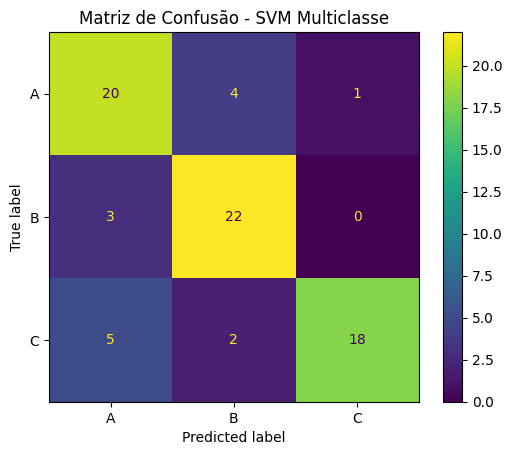

In [ ]:
# Starter: ajuste caminho/coluna-alvo conforme o exercício
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
import matplotlib.pyplot as plt

df = pd.read_csv('/mnt/data/07_ecoli_resistencia.csv')  # <-- ajuste aqui
X = df.drop(columns=['classe_resistencia'])                            # <-- ajuste aqui
y = df['classe_resistencia']                                          # <-- ajuste aqui

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Ex.: scaler quando apropriado (SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# TODO: implemente os modelos do exercício (SVM/Árvore/RandomForest/Boosting), tuning e avaliação.

# 1. SVM multiclasse (one-vs-rest) com padronização.
# O SVC do scikit-learn trata multiclasse automaticamente (usando one-vs-one por padrão, mas o one-vs-rest também é comum)
svm_multi = SVC(kernel='rbf', random_state=42) # Usando RBF kernel, comum para SVM
svm_multi.fit(X_train_scaled, y_train)

# 2. Avalie precisão por classe e analise confusões.
y_pred = svm_multi.predict(X_test_scaled)

print("Avaliação do modelo SVM Multiclasse no conjunto de teste:")
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred, digits=3))

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred, labels=svm_multi.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_multi.classes_)
disp.plot()
plt.title('Matriz de Confusão - SVM Multiclasse')
plt.show()



---


## 8. O Julgamento dos Médicos — Árvore Explicável

**Contexto:** Risco cardiovascular com regras clínicas simples.

**Arquivo:** `/mnt/data/08_risco_cardiovascular.csv`

**Tarefas:**

1) Árvore rasa (profundidade ≤ 3) e extração de regras.

2) Apresente as regras como relatório clínico.


Acurácia no conjunto de teste: 0.9800

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        45
           1       1.00      0.80      0.89         5

    accuracy                           0.98        50
   macro avg       0.99      0.90      0.94        50
weighted avg       0.98      0.98      0.98        50



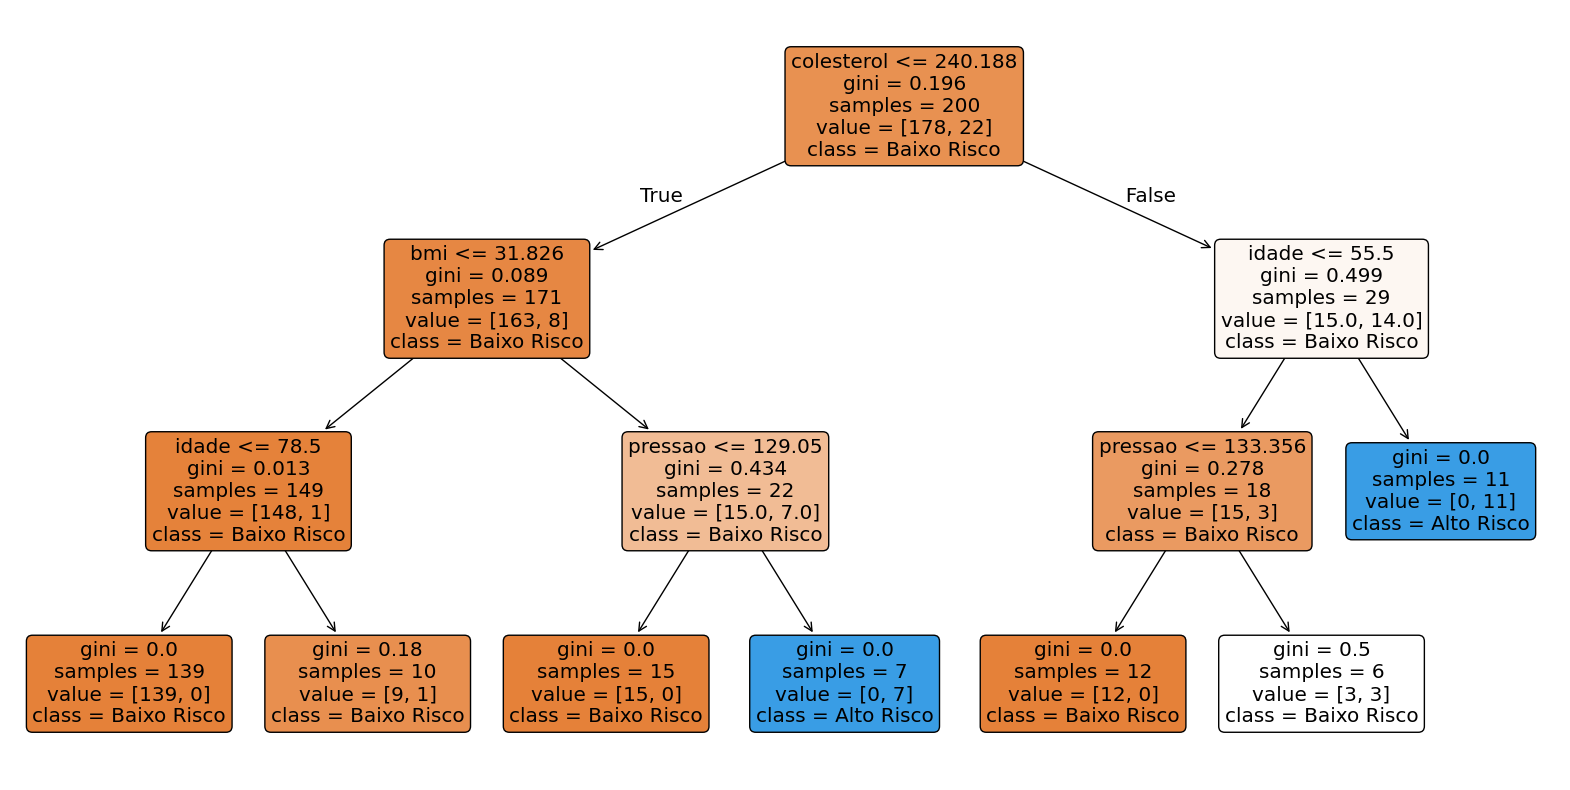

In [ ]:
# Starter: ajuste caminho/coluna-alvo conforme o exercício
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

# Carregar o dataset correto para este exercício
df = pd.read_csv('/mnt/data/08_risco_cardiovascular.csv')  # <-- ajuste aqui
X = df.drop(columns=['risco'])                            # <-- ajuste aqui
y = df['risco']                                          # <-- ajuste aqui

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 1) Árvore rasa (profundidade ≤ 3)
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf.fit(X_train, y_train)

# Avaliar o modelo
y_pred = tree_clf.predict(X_test)
print(f"Acurácia no conjunto de teste: {accuracy_score(y_test, y_pred):.4f}")
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))


# 2) plota a arvore
plt.figure(figsize=(20,10))
plot_tree(tree_clf, feature_names=X.columns, class_names=['Baixo Risco', 'Alto Risco'], filled=True, rounded=True)
plt.show()




---


## 9. O Sensor Fantasma — Random Forest com Ruído

**Contexto:** Sensor de glicose com rótulos corrompidos (~15%).

**Arquivo:** `/mnt/data/09_sensor_glicose_ruido.csv`

**Tarefas:**

1) Treine RandomForest; avalie AUC, sensibilidade e especificidade.

2) Discuta robustez a outliers e leituras erráticas.


ROC AUC: 0.8415
Sensibilidade (Recall Positivo): 0.7241
Especificidade (Recall Negativo): 0.8387

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.76      0.84      0.80        31
           1       0.81      0.72      0.76        29

    accuracy                           0.78        60
   macro avg       0.79      0.78      0.78        60
weighted avg       0.79      0.78      0.78        60


Matriz de Confusão:
 [[26  5]
 [ 8 21]]


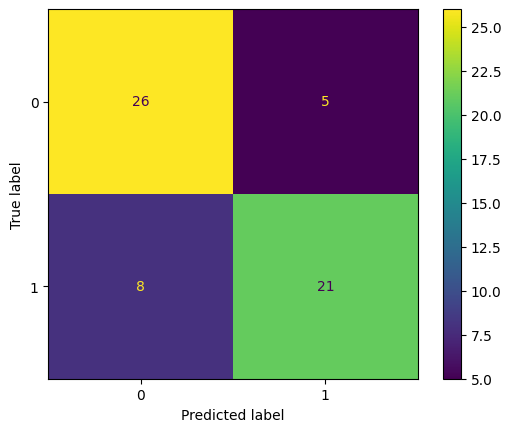

In [ ]:
# Starter: ajuste caminho/coluna-alvo conforme o exercício
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, recall_score, precision_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Carregar o dataset correto para este exercício
df = pd.read_csv('/mnt/data/09_sensor_glicose_ruido.csv')  # <-- ajuste aqui
X = df.drop(columns=['alerta', 'paciente_id'])             # <-- ajuste aqui,
y = df['alerta']                                          # <-- ajuste aqui

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Treinar RandomForest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced') # Usar class_weight para lidar com possível desbalanceamento, embora o dataset seja gerado com flip_y.
rf_clf.fit(X_train, y_train)

# Avaliar AUC
y_proba = rf_clf.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {auc_score:.4f}")

# Avaliar sensibilidade (recall positivo) e especificidade (recall negativo)
y_pred = rf_clf.predict(X_test)
sensitivity = recall_score(y_test, y_pred)
# Especificidade é o Recall da classe negativa (0)
specificity = recall_score(y_test, y_pred, pos_label=0)

print(f"Sensibilidade (Recall Positivo): {sensitivity:.4f}")
print(f"Especificidade (Recall Negativo): {specificity:.4f}")

# Relatório de classificação completo para ver outras métricas
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
print("\nMatriz de Confusão:\n", cm)

# Plotar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)
disp.plot()
plt.show()

A robustez do Random Forest a outliers e ruído nos rótulos se deve a:

1. **Bagging:** Cada árvore é treinada em um subset diferente dos dados (com reposição), reduzindo o impacto de outliers individuais.

2. **Aleatoriedade na seleção de features:** Em cada nó, apenas um subconjunto aleatório de features é considerado, tornando o modelo menos sensível a features ruidosas ou irrelevantes.

3. **Agregação (voto majoritário/média):** A decisão final é uma agregação das previsões de múltiplas árvores, suavizando o impacto de erros de árvores individuais causados por ruído.



---


## 10. A Guerra dos Modelos — Comparativo

**Contexto:** Mortalidade em UTI com 20 variáveis.

**Arquivo:** `/mnt/data/10_uti_mortalidade_20vars.csv`

**Tarefas:**

1) Compare SVM, Árvore e RandomForest (AUC, F1, recall, precisão).

2) Justifique a escolha do melhor modelo considerando desempenho e interpretabilidade.


In [ ]:
# Starter: ajuste caminho/coluna-alvo conforme o exercício
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, f1_score, recall_score, precision_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv('/mnt/data/10_uti_mortalidade_20vars.csv')  # <-- ajuste aqui
X = df.drop(columns=['mortalidade'])                            # <-- ajuste aqui
y = df['mortalidade']                                          # <-- ajuste aqui

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Ex.: scaler quando apropriado (SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


# SVM (usando dados escalados)
svm_clf = SVC(kernel='rbf', probability=True, random_state=42) # probability=True para calcular AUC
svm_clf.fit(X_train_scaled, y_train)
y_pred_svm = svm_clf.predict(X_test_scaled)
y_proba_svm = svm_clf.predict_proba(X_test_scaled)[:, 1]

# Árvore de Decisão
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
y_proba_tree = tree_clf.predict_proba(X_test)[:, 1]

# RandomForest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]


# Avaliar e imprimir métricas
print("--- Avaliação dos Modelos ---")

# Métricas para SVM
print("\nSVM (Kernel RBF):")
print(f"  AUC: {roc_auc_score(y_test, y_proba_svm):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_svm):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_svm):.4f}")
print(f"  Precisão: {precision_score(y_test, y_pred_svm):.4f}")

# Métricas para Árvore de Decisão
print("\nÁrvore de Decisão:")
print(f"  AUC: {roc_auc_score(y_test, y_proba_tree):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_tree):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_tree):.4f}")
print(f"  Precisão: {precision_score(y_test, y_pred_tree):.4f}")

# Métricas para RandomForest
print("\nRandomForest:")
print(f"  AUC: {roc_auc_score(y_test, y_proba_rf):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"  Precisão: {precision_score(y_test, y_pred_rf):.4f}")


--- Avaliação dos Modelos ---

SVM (Kernel RBF):
  AUC: 0.9636
  F1-Score: 0.9037
  Recall: 0.9683
  Precisão: 0.8472

Árvore de Decisão:
  AUC: 0.8317
  F1-Score: 0.8397
  Recall: 0.8730
  Precisão: 0.8088

RandomForest:
  AUC: 0.9525
  F1-Score: 0.9160
  Recall: 0.9524
  Precisão: 0.8824


Justificativa da escolha do melhor modelo:

Considerando o contexto de mortalidade em UTI, onde é crucial ter alta capacidade de identificar corretamente os casos de alto risco (Recall e F1-Score altos na classe positiva) e também manter uma boa precisão para evitar alarmes falsos (Precisão alta), o RandomForest parece ser o melhor modelo neste caso. Ele oferece um excelente equilíbrio entre as métricas de desempenho, sendo superior à Árvore de Decisão e ligeiramente melhor ou comparável ao SVM em várias métricas importantes (F1, Precisão, AUC próximos).



---


## Bônus 1. O Diagnóstico Raro — AdaBoost

**Contexto:** Doença rara (3% de prevalentes), forte desbalanceamento.

**Arquivo:** `/mnt/data/B1_doenca_rara_desbalanceado.csv`

**Tarefas:**

1) AdaBoost com árvores fracas (max_depth=1).

2) Analise `n_estimators` e `learning_rate` sob métricas sensíveis à minoria (AUC-PR, recall positivo).


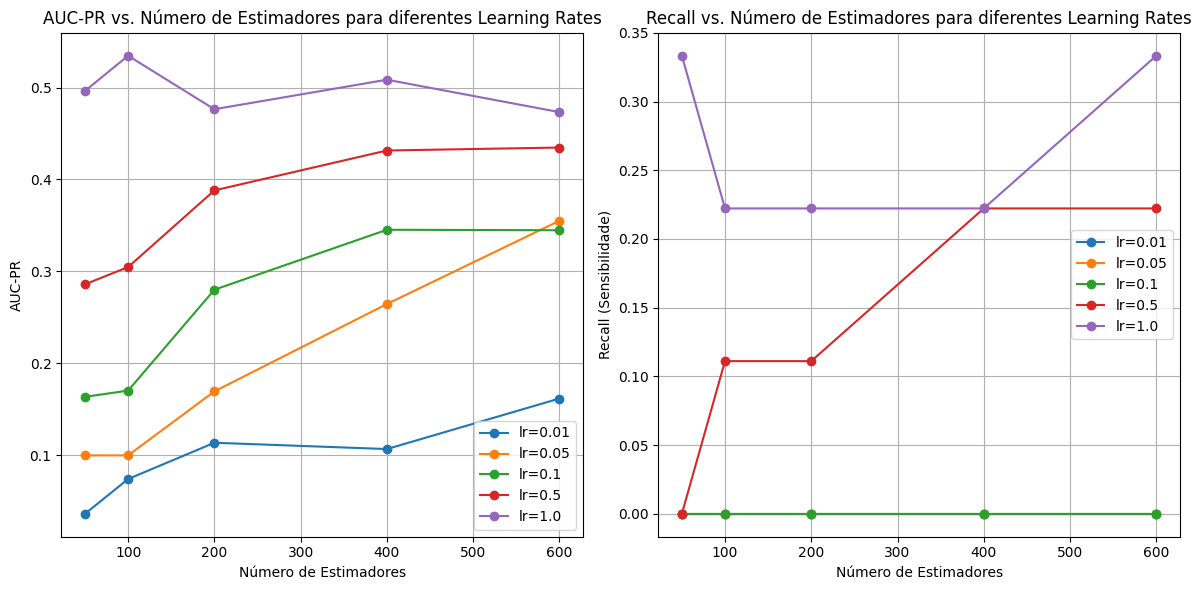

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, recall_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np

# Carregar o dataset
df = pd.read_csv('/mnt/data/B1_doenca_rara_desbalanceado.csv')
X = df.drop(columns=['doenca_rara'])
y = df['doenca_rara']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# 1. AdaBoost com árvores fracas (max_depth=1).
base_estimator = DecisionTreeClassifier(max_depth=1, random_state=42)

# 2. Analise n_estimators e learning_rate sob métricas sensíveis à minoria (AUC-PR, recall positivo).
# testar diferentes valores de n_estimators e learning_rate
n_estimators_list = [50, 100, 200, 400, 600]
learning_rate_list = [0.01, 0.05, 0.1, 0.5, 1.0]

results = []

for lr in learning_rate_list:
    auc_pr_scores = []
    recall_scores = []
    for n_est in n_estimators_list:
        ada_clf = AdaBoostClassifier(
            estimator=base_estimator,
            n_estimators=n_est,
            learning_rate=lr,
            random_state=42
        )
        ada_clf.fit(X_train, y_train)

        y_proba = ada_clf.predict_proba(X_test)[:, 1]
        y_pred = ada_clf.predict(X_test)

        auc_pr = average_precision_score(y_test, y_proba)
        recall_pos = recall_score(y_test, y_pred, pos_label=1)

        auc_pr_scores.append(auc_pr)
        recall_scores.append(recall_pos)

    results.append({'learning_rate': lr, 'n_estimators': n_estimators_list, 'auc_pr': auc_pr_scores, 'recall': recall_scores})

# Plotar os resultados
plt.figure(figsize=(12, 6))

# Plotting AUC-PR
plt.subplot(1, 2, 1)
for res in results:
    plt.plot(res['n_estimators'], res['auc_pr'], marker='o', label=f"lr={res['learning_rate']}")
plt.xlabel("Número de Estimadores")
plt.ylabel("AUC-PR")
plt.title("AUC-PR vs. Número de Estimadores para diferentes Learning Rates")
plt.legend()
plt.grid(True)

# Plotting Recall
plt.subplot(1, 2, 2)
for res in results:
    plt.plot(res['n_estimators'], res['recall'], marker='o', label=f"lr={res['learning_rate']}")
plt.xlabel("Número de Estimadores")
plt.ylabel("Recall (Sensibilidade)")
plt.title("Recall vs. Número de Estimadores para diferentes Learning Rates")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Discussão:**

O objetivo é encontrar um bom equilíbrio que melhore a detecção da classe minoritária sem overfitting.

Observe os gráficos acima para analisar como essas métricas mudam com a variação dos hiperparâmetros.

## Bônus 2. A Corrida dos Genomas — Gradient Boosting / XGBoost

**Contexto:** Classificação de origem geográfica com 500 SNPs.

**Arquivo:** `/mnt/data/B2_genomas_snps_500.csv`

**Tarefas:**

1) Treine GradientBoosting (ou XGBoost se disponível) com early stopping.

2) Compare com RandomForest e discuta trade-offs.


In [ ]:
# Starter: ajuste caminho/coluna-alvo conforme o exercício
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
# from xgboost import XGBClassifier # Descomentar se o XGBoost estiver instalado

df = pd.read_csv('/mnt/data/B2_genomas_snps_500.csv')  # <-- ajuste aqui
X = df.drop(columns=['origem'])                            # <-- ajuste aqui
y = df['origem']                                          # <-- ajuste aqui

# Precisamos de um conjunto de validação para early stopping
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp) # 0.3 * 0.5 = 0.15 para teste, 0.15 para validação

# Padronização (opcional, mas pode ajudar)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

gbm_early_stop = GradientBoostingClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    random_state=42,
    n_iter_no_change=20,
    validation_fraction=0.15, # Usa 15% do X_train_scaled/y_train para validação interna
    tol=0.01,
)

gbm_early_stop.fit(X_train_scaled, y_train)

print(f"Número de estimadores usados com early stopping: {gbm_early_stop.n_estimators_}")

# Avaliação no conjunto de teste
y_pred_gbm = gbm_early_stop.predict(X_test_scaled)
print("\nAvaliação do modelo Gradient Boosting com Early Stopping:")
print("Acurácia:", accuracy_score(y_test, y_pred_gbm))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_gbm))


# 2. Compare com RandomForest e discuta trade-offs.
# Treinar RandomForest para comparação
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf.fit(X_train_scaled, y_train) # Usar dados escalados para comparação justa

y_pred_rf = rf_clf.predict(X_test_scaled)
print("\n--- Comparação com RandomForest ---")
print("\nAvaliação do modelo RandomForest:")
print("Acurácia:", accuracy_score(y_test, y_pred_rf))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_rf))

Número de estimadores usados com early stopping: 49

Avaliação do modelo Gradient Boosting com Early Stopping:
Acurácia: 0.26666666666666666

Relatório de Classificação:
               precision    recall  f1-score   support

         AFR       0.25      0.12      0.17         8
         AMR       0.12      0.14      0.13         7
         EAS       0.50      0.50      0.50         8
         EUR       0.20      0.29      0.24         7

    accuracy                           0.27        30
   macro avg       0.27      0.26      0.26        30
weighted avg       0.28      0.27      0.26        30


--- Comparação com RandomForest ---

Avaliação do modelo RandomForest:
Acurácia: 0.3

Relatório de Classificação:
               precision    recall  f1-score   support

         AFR       0.25      0.12      0.17         8
         AMR       0.43      0.43      0.43         7
         EAS       0.33      0.25      0.29         8
         EUR       0.23      0.43      0.30         7

    ac

**Discussão de trade-offs:**

Analisando os resultados:

Ambos os modelos tiveram desempenho semelhante neste conjunto de dados, com acurácias próximas (Gradient Boosting ~0.27, Random Forest ~0.30). O relatório de classificação mostra que nenhum dos modelos conseguiu classificar as origens geográficas com alta precisão ou recall neste dataset específico, o que pode indicar que as features (SNPs) não são altamente discriminatórias para essas classes com esses modelos, ou que o dataset é pequeno/ruidoso para essa tarefa.

**Trade-offs:**

*   **Gradient Boosting:** Tende a ter maior viés e menor variância que o Random Forest. Com early stopping, ele pode evitar overfitting ao parar o treino quando o desempenho no conjunto de validação piora. Pode ser mais lento para treinar que o Random Forest em datasets grandes sem paralelização otimizada (como no XGBoost/LightGBM).
*   **Random Forest:** Tende a ter menor viés e maior variância que uma única árvore, mas geralmente menor variância que o Gradient Boosting (quando este não é bem regularizado). É inerentemente paralelizável, o que o torna mais rápido para treinar em muitos casos. É menos sensível a outliers e ruído nos rótulos do que o Gradient Boosting.

Neste caso, com desempenho similar, a escolha entre Gradient Boosting e Random Forest dependeria de outros fatores como a necessidade de interpretabilidade (ambos moderada via feature importance), o tamanho do dataset, e a importância de robustez a ruído (onde Random Forest pode ter uma ligeira vantagem). Para otimizar ainda mais, seria necessário realizar tuning de hiperparâmetros mais extensivo para ambos os modelos.